# Library

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats
from statsmodels.stats import weightstats as sms
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_decomposition,ensemble,metrics,svm
from sklearn.model_selection import cross_validate, train_test_split

# Data Preprocessing

In [2]:
rawdata=pd.read_csv("./data/train.csv")
tdata=pd.DataFrame(rawdata)
tdata.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
print("========================================Statistic==========================================")
print(tdata.describe())
print(tdata.sum())
print("==========================================Feature==========================================")
print(tdata.info())
print("==========================================Feature==========================================")
print(tdata.columns)
print("=======================================Data Dimation=======================================")
print(tdata.shape)

========================================Statistic==========================================
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  51

# Null Data

In [4]:
null_column=[ tdata.columns[index] for index, i in enumerate(tdata.isnull().any()) if i==True] 
print("Nulldata is in feature :", null_column)

Nulldata is in feature : ['Age', 'Cabin', 'Embarked']


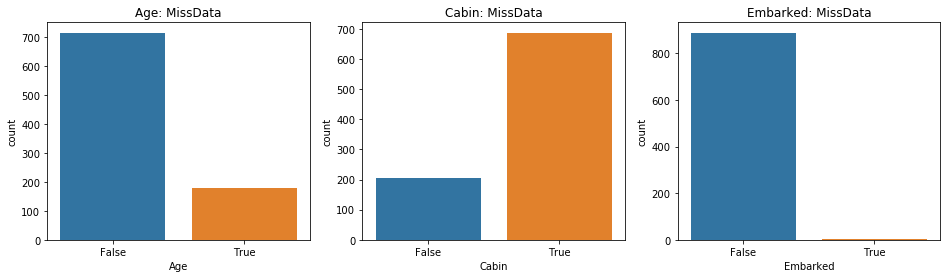

In [5]:
plt.figure(figsize=(16,4))
y=0
for i in null_column:
    plt.subplot2grid((1,3),(0,y),colspan=1)
    sns.countplot(tdata[i].isnull())
    plt.title(i+": MissData")
    y+=1
    
plt.show()

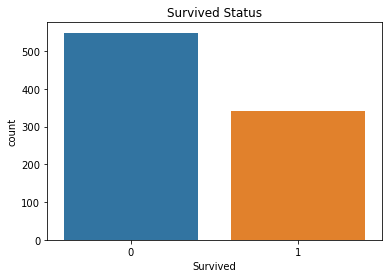

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(tdata["Survived"])
plt.title("Survived Status")
plt.show()

### Fill Age By Name & Sex

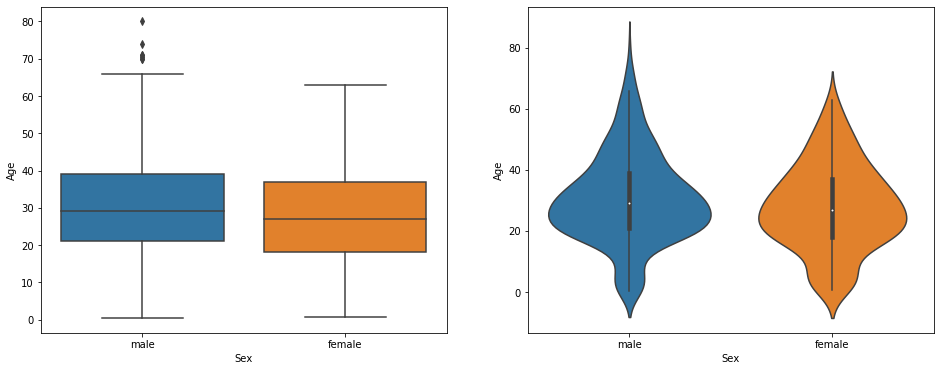

In [7]:
plt.figure(figsize=(16,6))
plt.subplot2grid((1,2),(0,0),colspan=1)
sns.boxplot(x = "Sex", y = "Age", data = tdata)
plt.subplot2grid((1,2),(0,1),colspan=1)
sns.violinplot(x = "Sex", y = "Age" , data = tdata)
plt.show()

In [8]:
female_describe=tdata.groupby("Sex").get_group("female").describe()
female_describe.columns=[i+".female" for i in female_describe.columns]
male_describe=tdata.groupby("Sex").get_group("male").describe()
male_describe.columns=[i+".male" for i in male_describe.columns]
f_m_describe=pd.concat([male_describe, female_describe], axis=1)
print(f_m_describe[["Age.male", "Age.female"]])
male_data=tdata[tdata["Sex"]=="male"].dropna(subset=["Age"])
female_data=tdata[tdata["Sex"]=="female"].dropna(subset=["Age"])
# female_data["Age"].values (series/dataframe 轉成 np.array)
print("(Z-Score, P-value)")
sms.CompareMeans.from_data(male_data["Age"].values, female_data["Age"].values).ztest_ind()

         Age.male  Age.female
count  453.000000  261.000000
mean    30.726645   27.915709
std     14.678201   14.110146
min      0.420000    0.750000
25%     21.000000   18.000000
50%     29.000000   27.000000
75%     39.000000   37.000000
max     80.000000   63.000000
(Z-Score, P-value)


(2.499206354920835, 0.01244718076724336)

In [9]:
### 稱謂分割
tNdata=tdata
tNdata["FirstName"],tNdata["SecondName"]=tNdata["Name"].str.split(",", 2, expand=False).str
tNdata["SecondName"]=tNdata["SecondName"].str.replace("L.","L").str.replace(" ","")
tNdata["NameTitle"],tNdata["SecondName"]=tNdata["SecondName"].str.split(".", 2, expand=False).str
tNdata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstName,SecondName,NameTitle
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,OwenHarris,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,JohnBradley(FlorenceBriggsThayer),Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Lina,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,JacquesHeath(LlyMayPeel),Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,WilliamHenry,Mr


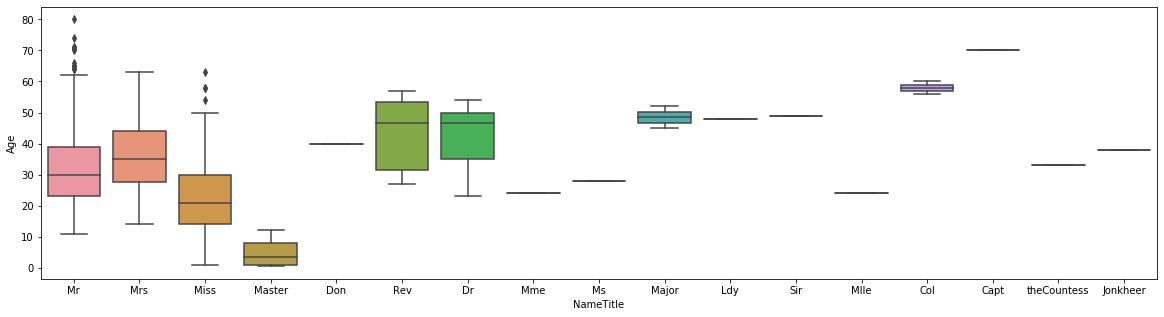

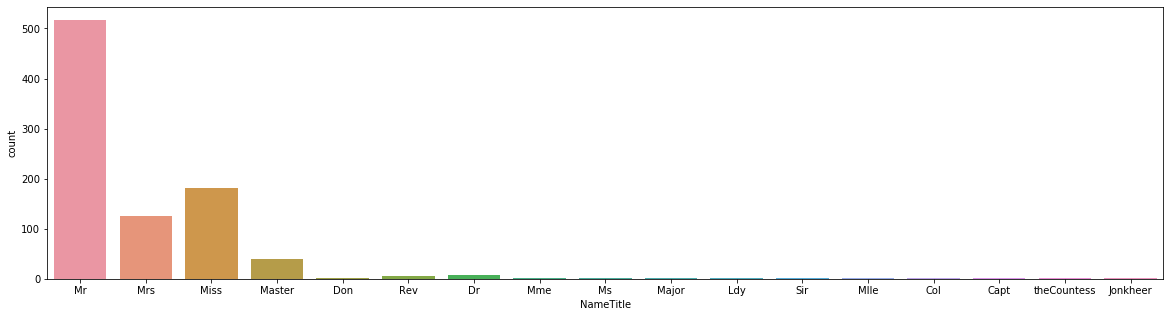

In [10]:
plt.figure(figsize=(20,5))
sns.boxplot(x="NameTitle", y="Age", data=tNdata)
plt.show()
plt.figure(figsize=(20,5))
sns.countplot(tNdata["NameTitle"])
plt.show()

In [11]:
# Fill age missing data by name title avarge
Nametitle_average=tNdata.groupby("NameTitle").mean()
cleanAgeData = pd.DataFrame()
Ngroups=tNdata.groupby("NameTitle")
for Name, Ngroup in Ngroups:
    Ngroup.fillna(value={"Age" : Nametitle_average.loc[Name, "Age"]}, inplace = True)
    cleanAgeData = cleanAgeData.append(Ngroup)

c:\users\zero1\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Deal Embarked missing data with 

In [12]:
tdata[tdata["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstName,SecondName,NameTitle
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Icard,Amelie,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Stone,GeorgeNelson(MarthaEvelyn),Mrs


--------S----------
       PassengerId    Survived      Pclass         Age       SibSp  \
count   644.000000  644.000000  644.000000  554.000000  644.000000   
mean    449.527950    0.336957    2.350932   29.445397    0.571429   
std     256.942044    0.473037    0.789402   14.143192    1.216600   
min       1.000000    0.000000    1.000000    0.670000    0.000000   
25%     225.750000    0.000000    2.000000   21.000000    0.000000   
50%     447.500000    0.000000    3.000000   28.000000    0.000000   
75%     673.250000    1.000000    3.000000   38.000000    1.000000   
max     889.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  644.000000  644.000000  
mean     0.413043   27.079812  
std      0.853253   35.887993  
min      0.000000    0.000000  
25%      0.000000    8.050000  
50%      0.000000   13.000000  
75%      0.000000   27.900000  
max      6.000000  263.000000  
--------C----------
       PassengerId    Survived      Pclas

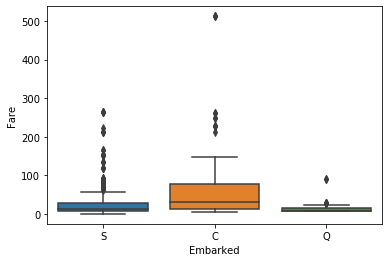

In [13]:
sns.boxplot(x="Embarked", y="Fare", data=tdata)
for i in ["S","C","Q"]:
    print("--------{}----------".format(i))
    print(tdata.groupby("Embarked").get_group(i).describe())
cleanAgeData = cleanAgeData.fillna({"Embarked":"C"})

### Drop Cabin (missing over helf)

In [14]:
cleanAgeData = cleanAgeData.drop(["Cabin"],axis=1)

In [15]:
cleanAgeData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 745 to 759
Data columns (total 14 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
FirstName      891 non-null object
SecondName     891 non-null object
NameTitle      891 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 80.1+ KB


# Data Visualization

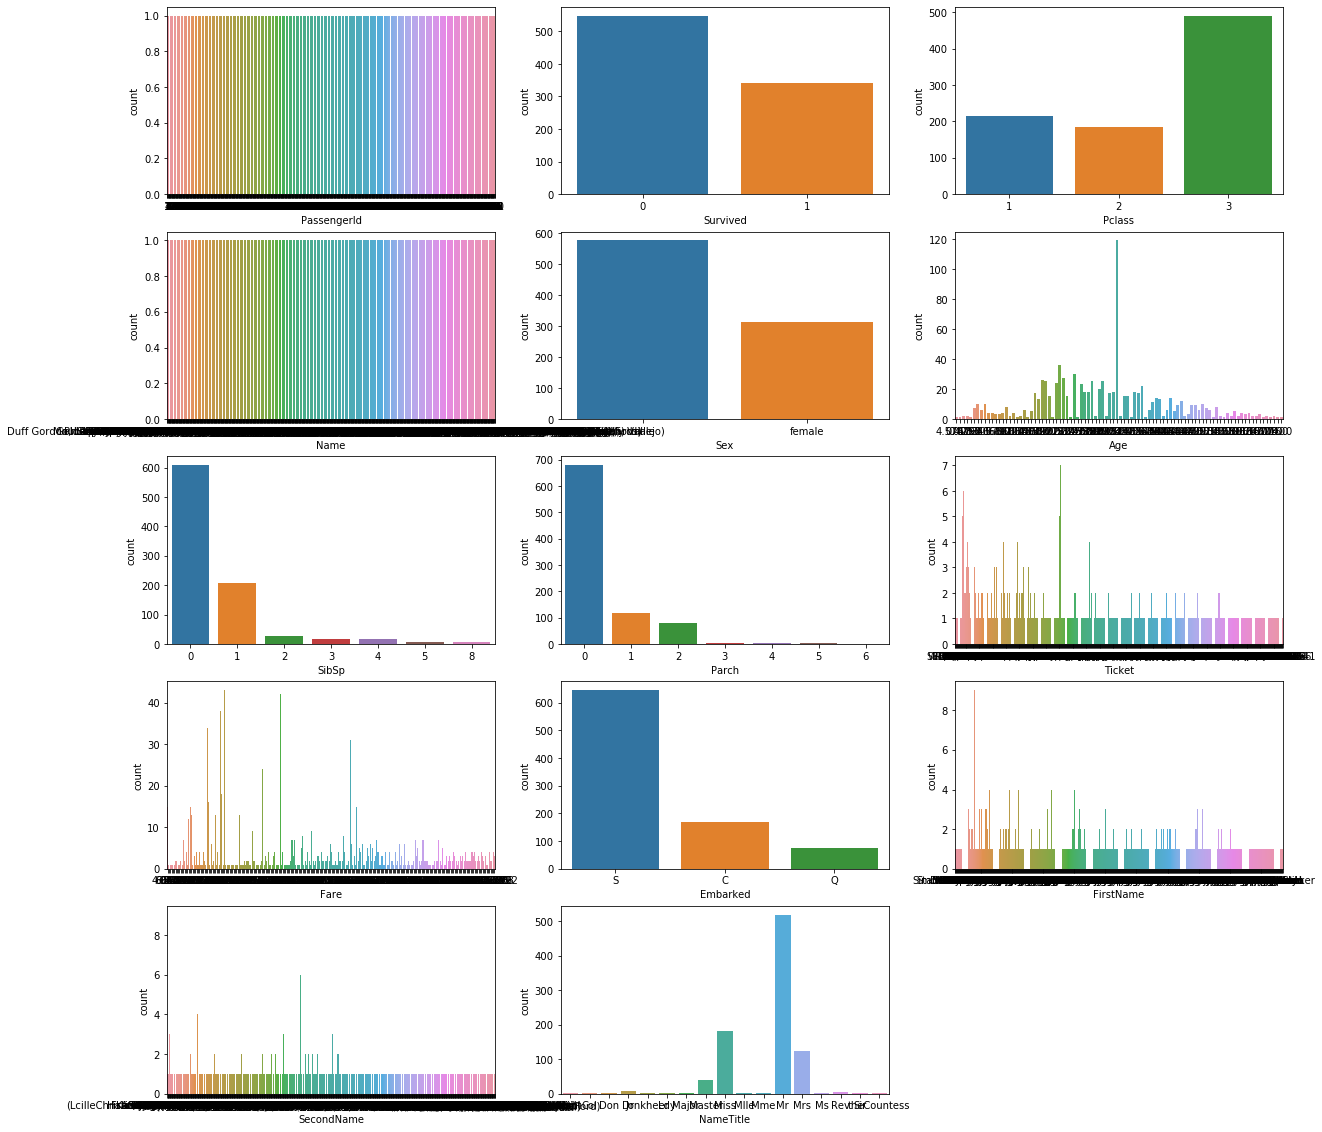

In [16]:
#Feature Selection
plt.figure(figsize=(20,20))
x,y=0,0
for i in cleanAgeData.columns:
    plt.subplot2grid((5,3),(x,y),colspan=1,rowspan=1)
    sns.countplot(cleanAgeData[i])
    y+=1
    if y!=0 and y%3==0:
        x+=1
        y=0
plt.show()

In [17]:
# Find Feature and Survived relation
def CalculateSurivedRate(*Args):
    plt.figure(figsize=(20,20))
    columnslist=[*Args]
    print(columnslist)
    x,y=0,0
    for colname in columnslist:
        elist={}
        groups = cleanAgeData.groupby(colname)
        for name,group in groups:
            survived = group["Survived"]
            count1, count0 = 0, 0
            for i in survived:
                if i == 1:
                    count1+=1
                else:
                    count0+=1
            elist[name]=count1/(count1+count0)
        
        delist = pd.DataFrame(elist,index=[colname])
        plt.subplot2grid((math.ceil(len(columnslist)/3),3),(x,y),colspan=1,rowspan=1)
        sns.barplot(data=delist) #delist.plot(kind="bar")
#         plt.legend(labels=delist.columns)
        plt.title(colname)
        y+=1
        if y!=0 and y%3==0:
            x+=1
            y=0
    plt.show()

['Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Embarked', 'NameTitle']


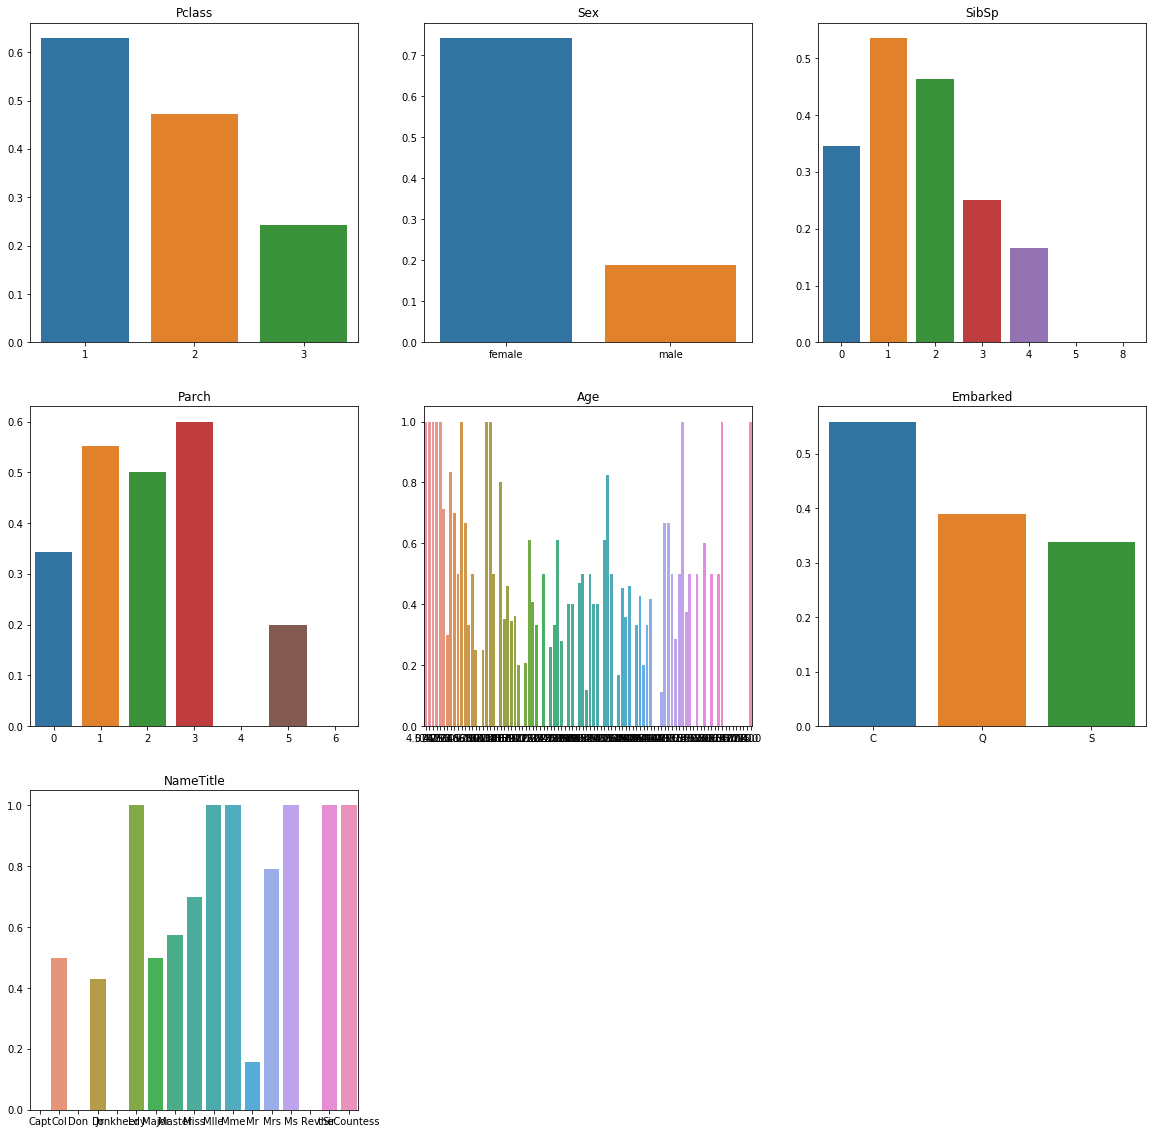

In [18]:
CalculateSurivedRate('Pclass', 'Sex', 'SibSp', 'Parch', 'Age', 'Embarked', 'NameTitle')

<Figure size 1152x1440 with 0 Axes>

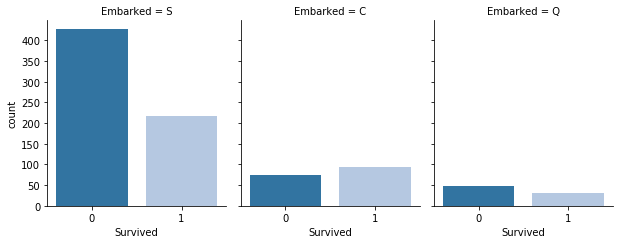

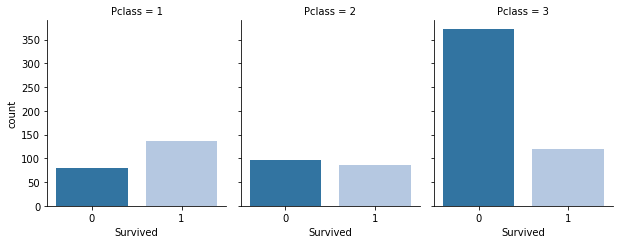

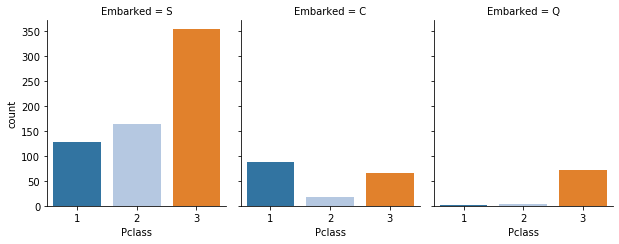

In [19]:
plt.figure(figsize=(16,20))
sns.catplot("Survived", col="Embarked", col_wrap=4,
            data=cleanAgeData,
            kind="count", height=3.5, aspect=.8,
            palette='tab20')
plt.show()
sns.catplot("Survived", col="Pclass", col_wrap=4,
            data=cleanAgeData,
            kind="count", height=3.5, aspect=.8,
            palette='tab20')
plt.show()
sns.catplot("Pclass", col="Embarked", col_wrap=4,
            data=cleanAgeData,
            kind="count", height=3.5, aspect=.8,
            palette='tab20')
plt.show()

# Feature encode

In [20]:
labelencoder = LabelEncoder()
changeLabeldata = cleanAgeData.drop(["FirstName","SecondName","Name"],axis=1) #移除不納入本次模組的特徵
for i in changeLabeldata.columns:
    if changeLabeldata[i].dtypes == object:
        changeLabeldata[i] = labelencoder.fit_transform(changeLabeldata[i])
changeLabeldata.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,NameTitle
745,746,0,1,1,70.0,1,1,680,71.0000,2,0
647,648,1,1,1,56.0,0,0,69,35.5000,0,1
694,695,0,1,1,60.0,0,0,48,26.5500,2,1
30,31,0,1,1,40.0,0,0,598,27.7208,0,2
245,246,0,1,1,44.0,2,0,92,90.0000,1,3


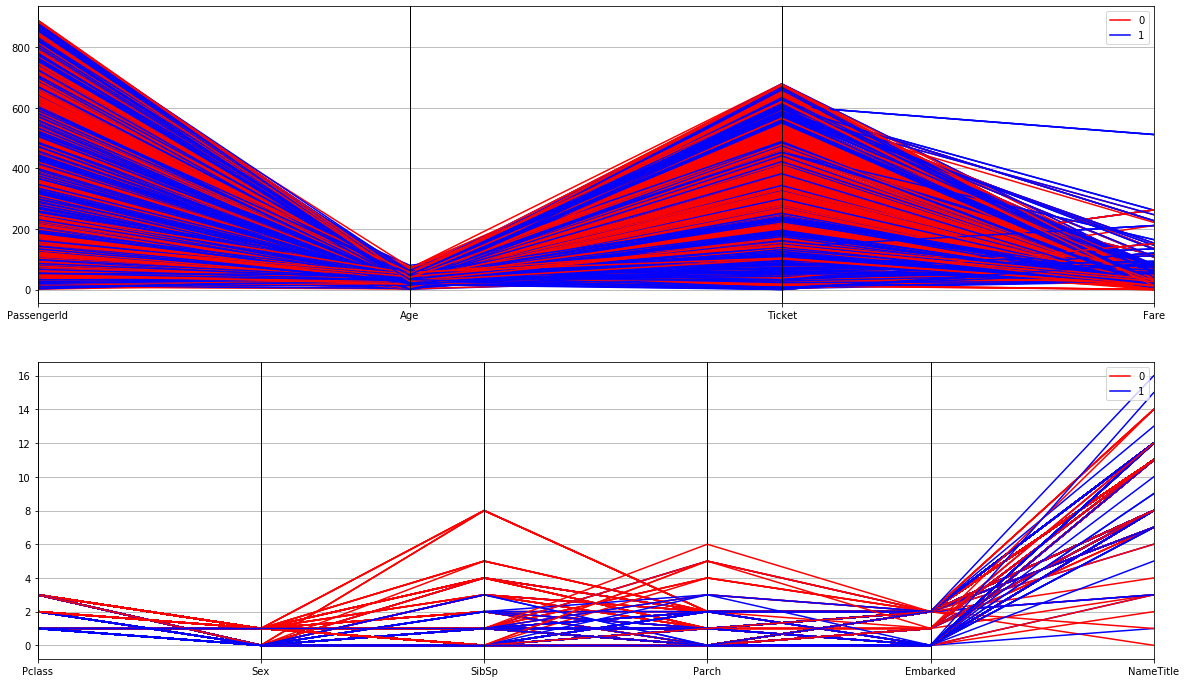

In [21]:
plt.figure(figsize=(20,12))
plt.subplot2grid((2,1),(0,0),colspan=1)
parallel_coordinates(changeLabeldata.drop(["Pclass", "Sex", "SibSp", "Parch", "Embarked", "NameTitle"], axis=1) , "Survived", color=["red", "blue"])
plt.subplot2grid((2,1),(1,0),colspan=1)
parallel_coordinates(changeLabeldata.drop(["PassengerId", "Age", "Ticket", "Fare"], axis=1) , "Survived", color=["red", "blue"])
plt.show()

# Implement validation data

In [22]:
titanic_x = changeLabeldata.iloc[:,2:]
titanic_y = changeLabeldata["Survived"]
train_X, test_X, train_y, test_y = train_test_split(titanic_x, titanic_y, test_size = 0.3, random_state = 42)
#random_state固定驗證資料

In [23]:
print(train_X.info())
print("===================")
print(test_X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 373 to 216
Data columns (total 9 columns):
Pclass       623 non-null int64
Sex          623 non-null int32
Age          623 non-null float64
SibSp        623 non-null int64
Parch        623 non-null int64
Ticket       623 non-null int32
Fare         623 non-null float64
Embarked     623 non-null int32
NameTitle    623 non-null int32
dtypes: float64(2), int32(4), int64(3)
memory usage: 38.9 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 804 to 349
Data columns (total 9 columns):
Pclass       268 non-null int64
Sex          268 non-null int32
Age          268 non-null float64
SibSp        268 non-null int64
Parch        268 non-null int64
Ticket       268 non-null int32
Fare         268 non-null float64
Embarked     268 non-null int32
NameTitle    268 non-null int32
dtypes: float64(2), int32(4), int64(3)
memory usage: 16.8 KB
None


# Select Algorithm

## 1.Random Forest

In [24]:
from sklearn import ensemble
forest = ensemble.RandomForestClassifier(n_estimators=500)
forest_fit = forest.fit(train_X, train_y)
forest_predict = forest_fit.predict(test_X)
print(forest_predict)

[0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 0
 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1
 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1
 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1
 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0
 0 0 0 0 1 0 0 0 0]


### Tree Visualization

In [25]:
from sklearn.tree import export_graphviz
estimator = forest_fit.estimators_[5]
feature_name=[i for i in train_X.columns]
dot_data = export_graphviz(estimator, 
                           out_file= None, 
                           feature_names = feature_name,
                           class_names = ["Died","Survived"],
                           rounded = True, proportion = False, 
                           precision = 2, filled = True)


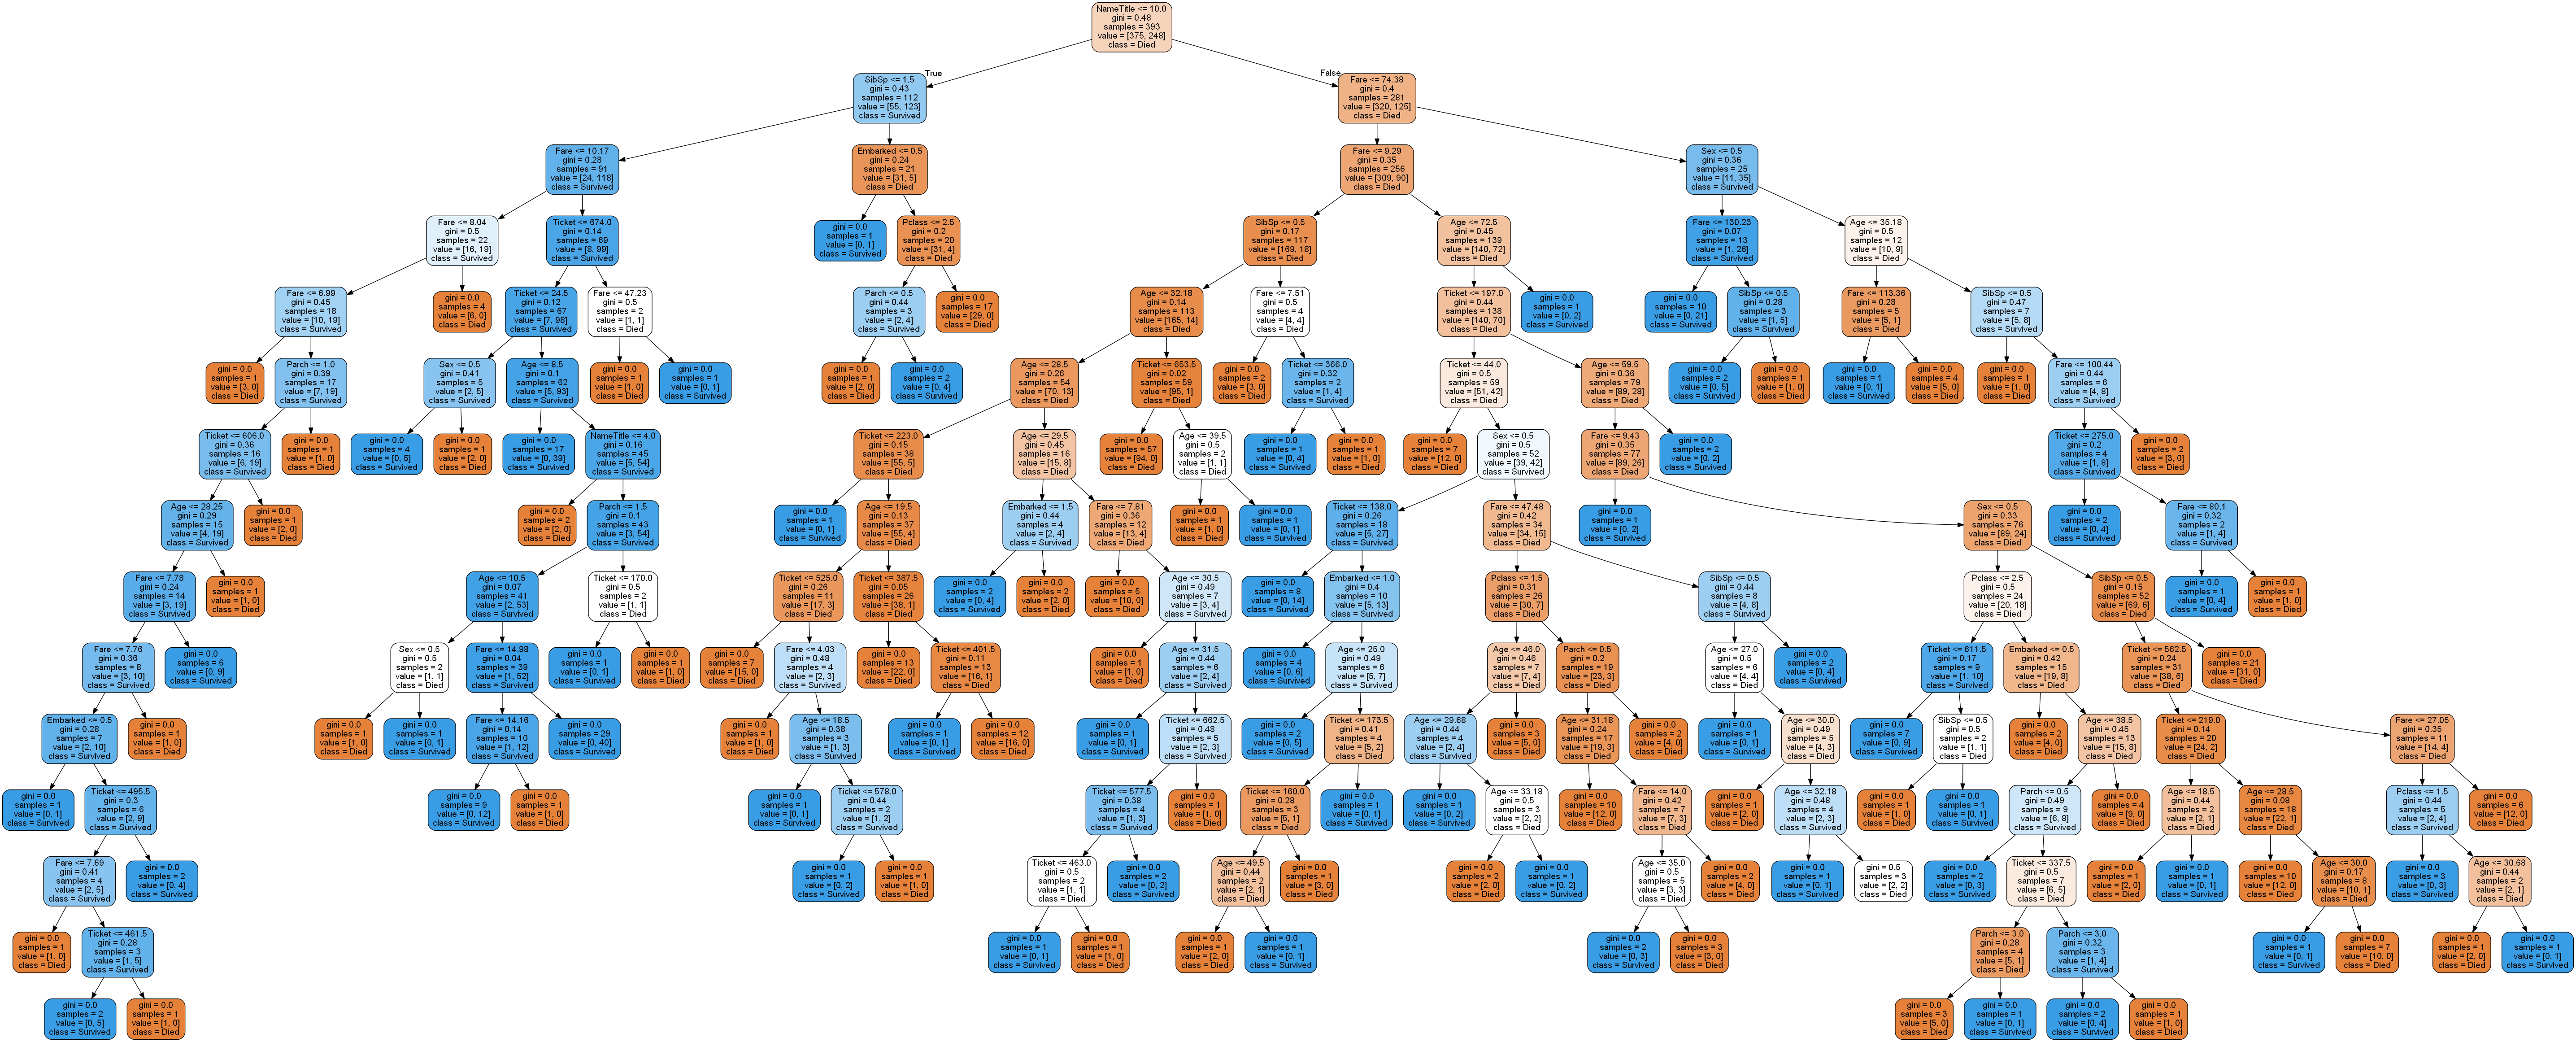

In [26]:
# Display in jupyter notebook
from IPython.display import Image
import pydotplus
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Predict Score

In [27]:
RFauc = metrics.roc_auc_score(test_y, forest_predict)
print(RFauc)
print(metrics.classification_report(test_y, forest_predict))

0.8470978834410388
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       167
           1       0.82      0.80      0.81       101

    accuracy                           0.86       268
   macro avg       0.85      0.85      0.85       268
weighted avg       0.86      0.86      0.86       268



## 2.SVM

In [28]:
from sklearn import svm
svc = svm.SVC()
svc_fit = svc.fit(train_X, train_y)
svc_predict = svc_fit.predict(test_X)
print(svc_predict)

[0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0
 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 0 1 0 0 1 0]


In [29]:
SVMauc = metrics.roc_auc_score(test_y, svc_predict)
print(SVMauc)
print(metrics.classification_report(test_y, svc_predict))

0.6322701132388687
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       167
           1       0.69      0.37      0.48       101

    accuracy                           0.70       268
   macro avg       0.69      0.63      0.63       268
weighted avg       0.69      0.70      0.67       268



## 3.Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg_fit = logreg.fit(train_X, train_y)
logreg_predict = logreg_fit.predict(test_X)

c:\users\zero1\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
logreg_predict

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0], dtype=int64)

In [32]:
LogRegauc = metrics.roc_auc_score(test_y, logreg_predict)
print(LogRegauc)
print(metrics.classification_report(test_y, logreg_predict))

0.8015058990929033
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       167
           1       0.78      0.72      0.75       101

    accuracy                           0.82       268
   macro avg       0.81      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



## KNN

In [33]:
from sklearn import neighbors
Knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
Knn_fit = Knn.fit(train_X, train_y)
Knn_predict = Knn_fit.predict(test_X)
print(Knn_predict)

[1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 0
 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0
 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0
 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0
 1 0 1 0 1 0 0 0 0]


In [34]:
Knnauc = metrics.roc_auc_score(test_y, Knn_predict)
print(Knnauc)
print(metrics.classification_report(test_y, Knn_predict))

0.6854508804173831
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       167
           1       0.65      0.54      0.59       101

    accuracy                           0.72       268
   macro avg       0.70      0.69      0.69       268
weighted avg       0.71      0.72      0.71       268



# Compare 4 module

            ModelName     Score
0         RanomForest  0.847098
1                 SVM  0.632270
2  LogisticRegression  0.801506
3                 KNN  0.685451


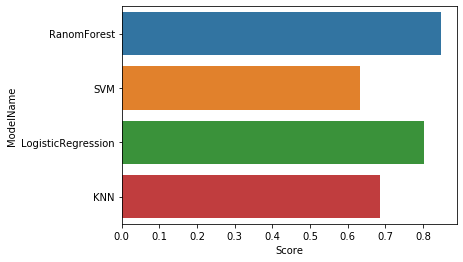

In [35]:
model_score = pd.DataFrame({
    "ModelName":["RanomForest", "SVM", "LogisticRegression", "KNN"],
    "Score":[RFauc,SVMauc,LogRegauc,Knnauc]
})
print(model_score)
sns.barplot(y="ModelName", x="Score",data=model_score)
plt.show()